# Week 8, Day 7: ML for Trading - Interview Questions & Review

## Learning Objectives
- Review key ML concepts for trading interviews
- Practice common interview questions
- Understand pitfalls and best practices
- Build intuition for ML in finance

## Key Topics Covered This Week
1. Decision Trees & Random Forests
2. Gradient Boosting (XGBoost, LightGBM)
3. Feature Engineering
4. Walk-Forward Validation
5. Ensemble Methods
6. Backtesting with Transaction Costs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

print("Week 8 Review: ML for Trading")
print("="*50)

Week 8 Review: ML for Trading


---
## Interview Question 1: Explain Look-Ahead Bias

**Question**: What is look-ahead bias and how do you prevent it in ML for trading?

### Answer:

**Look-ahead bias** occurs when you use information that wouldn't have been available at the time of making a trading decision.

**Common causes:**
1. Using future prices to calculate features
2. Fitting models on the entire dataset before trading
3. Using corporate actions data before announcement

**Prevention:**
- Lag all features by at least 1 day: `feature.shift(1)`
- Use walk-forward validation
- Ensure point-in-time data

In [2]:
# Example: Correct vs Incorrect feature creation

prices = pd.Series([100, 102, 101, 105, 103], index=pd.date_range('2024-01-01', periods=5))

print("WRONG - Using today's data to predict today:")
wrong_feature = prices.pct_change()  # Return includes today's info
print(wrong_feature)

print("\nCORRECT - Using yesterday's data to predict today:")
correct_feature = prices.pct_change().shift(1)  # Lagged by 1 day
print(correct_feature)

print("\n✓ Always shift features by at least 1 period!")

WRONG - Using today's data to predict today:
2024-01-01         NaN
2024-01-02    0.020000
2024-01-03   -0.009804
2024-01-04    0.039604
2024-01-05   -0.019048
Freq: D, dtype: float64

CORRECT - Using yesterday's data to predict today:
2024-01-01         NaN
2024-01-02         NaN
2024-01-03    0.020000
2024-01-04   -0.009804
2024-01-05    0.039604
Freq: D, dtype: float64

✓ Always shift features by at least 1 period!


---
## Interview Question 2: Random Forest vs Gradient Boosting

**Question**: Compare Random Forest and Gradient Boosting. When would you use each?

### Answer:

| Aspect | Random Forest | Gradient Boosting |
|--------|--------------|-------------------|
| **Training** | Parallel (bagging) | Sequential (boosting) |
| **Bias-Variance** | Reduces variance | Reduces bias |
| **Overfitting** | More resistant | More prone |
| **Speed** | Faster training | Slower training |
| **Tuning** | Easier | More hyperparameters |

**When to use:**
- **Random Forest**: Noisy data, quick baseline, less tuning time
- **Gradient Boosting**: Maximizing accuracy, structured data, when you can tune properly

In [3]:
# Demonstration: Bias-Variance tradeoff
np.random.seed(42)

# Generate synthetic data
n_samples = 500
X = np.random.randn(n_samples, 10)
y = (X[:, 0] + 0.5*X[:, 1] - 0.3*X[:, 2] + np.random.randn(n_samples)*0.5 > 0).astype(int)

# Time series split
tscv = TimeSeriesSplit(n_splits=5)

# Compare models
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)

rf_scores = cross_val_score(rf, X, y, cv=tscv, scoring='accuracy')
gb_scores = cross_val_score(gb, X, y, cv=tscv, scoring='accuracy')

print("Model Comparison (Time Series CV)")
print("="*50)
print(f"Random Forest: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")
print(f"Gradient Boosting: {gb_scores.mean():.4f} ± {gb_scores.std():.4f}")
print(f"\nRF has lower variance: {rf_scores.std() < gb_scores.std()}")

Model Comparison (Time Series CV)
Random Forest: 0.8289 ± 0.0279
Gradient Boosting: 0.8289 ± 0.0406

RF has lower variance: True


---
## Interview Question 3: Feature Importance

**Question**: How do tree-based models calculate feature importance? What are the limitations?

### Answer:

**Methods:**
1. **Gini Importance**: Sum of decrease in impurity across all splits on that feature
2. **Permutation Importance**: Drop in accuracy when feature values are shuffled

**Formula for Gini Importance:**
$$\text{Importance}(f) = \sum_{\text{splits on } f} n_{\text{node}} \cdot \Delta\text{Gini}$$

**Limitations:**
- Biased toward high-cardinality features
- Correlated features share importance
- Doesn't show direction of effect

In [4]:
# Example: Feature importance comparison
from sklearn.inspection import permutation_importance

# Train model
rf.fit(X, y)

# Gini importance
gini_imp = pd.DataFrame({
    'feature': [f'X{i}' for i in range(10)],
    'gini_importance': rf.feature_importances_
}).sort_values('gini_importance', ascending=False)

# Permutation importance
perm_imp = permutation_importance(rf, X, y, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({
    'feature': [f'X{i}' for i in range(10)],
    'perm_importance': perm_imp.importances_mean
}).sort_values('perm_importance', ascending=False)

print("Feature Importance Comparison")
print("="*50)
print("\nGini Importance (top 5):")
print(gini_imp.head().to_string(index=False))
print("\nPermutation Importance (top 5):")
print(perm_df.head().to_string(index=False))

Feature Importance Comparison

Gini Importance (top 5):
feature  gini_importance
     X0         0.460307
     X1         0.218569
     X2         0.088131
     X6         0.049593
     X4         0.035563

Permutation Importance (top 5):
feature  perm_importance
     X0           0.3244
     X1           0.1546
     X2           0.0706
     X6           0.0168
     X9           0.0106


---
## Interview Question 4: Walk-Forward Validation

**Question**: Why can't we use standard K-fold cross-validation for trading strategies?

### Answer:

**Problem with K-fold:**
- Shuffles data randomly
- Test folds can contain data from before training folds
- Violates temporal causality → **DATA LEAKAGE**

**Walk-forward validation:**
- Always trains on past, tests on future
- Simulates real trading conditions
- Models are retrained periodically (like in production)

**Key parameters:**
- Training window (rolling vs expanding)
- Test window (retraining frequency)
- Purging (gap between train and test)
- Embargo (buffer after test)

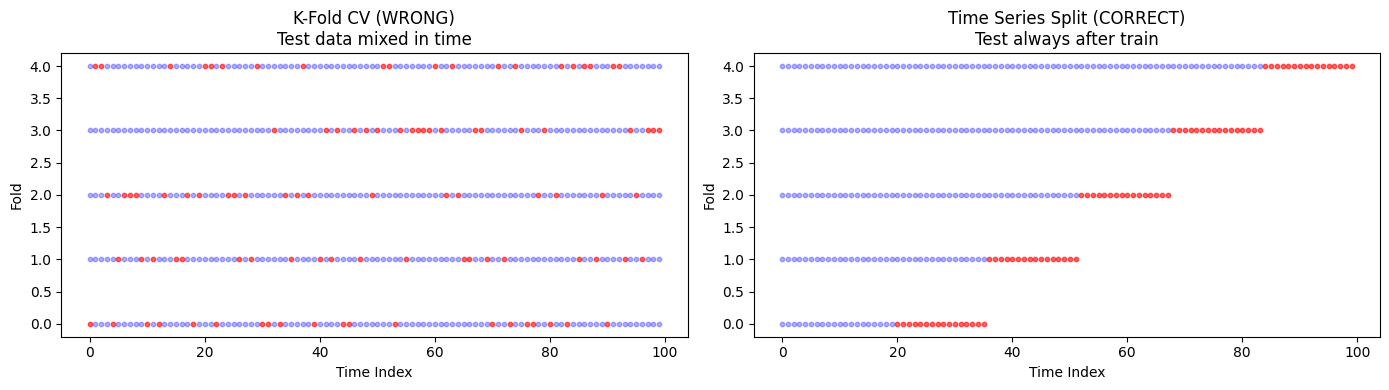

In [5]:
# Visual comparison of K-fold vs Time Series Split
from sklearn.model_selection import KFold, TimeSeriesSplit

n = 100
X_demo = np.arange(n).reshape(-1, 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# K-Fold (WRONG for time series)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X_demo)):
    axes[0].scatter(train, [i]*len(train), c='blue', alpha=0.3, s=10)
    axes[0].scatter(test, [i]*len(test), c='red', alpha=0.6, s=10)
axes[0].set_title('K-Fold CV (WRONG)\nTest data mixed in time')
axes[0].set_xlabel('Time Index')
axes[0].set_ylabel('Fold')

# Time Series Split (CORRECT)
tscv = TimeSeriesSplit(n_splits=5)
for i, (train, test) in enumerate(tscv.split(X_demo)):
    axes[1].scatter(train, [i]*len(train), c='blue', alpha=0.3, s=10)
    axes[1].scatter(test, [i]*len(test), c='red', alpha=0.6, s=10)
axes[1].set_title('Time Series Split (CORRECT)\nTest always after train')
axes[1].set_xlabel('Time Index')
axes[1].set_ylabel('Fold')

plt.tight_layout()
plt.show()

---
## Interview Question 5: Overfitting in ML Trading

**Question**: How do you detect and prevent overfitting in ML trading strategies?

### Answer:

**Detection:**
- Large gap between train and test accuracy
- Test performance degrades over time
- Model changes predictions drastically with small data changes

**Prevention:**
1. **Regularization**: L1/L2 penalties, max_depth limits
2. **Early stopping**: Monitor validation loss
3. **Feature selection**: Remove noisy/irrelevant features
4. **Ensemble methods**: Average multiple models
5. **Cross-validation**: Use walk-forward properly
6. **Occam's razor**: Simpler models generalize better

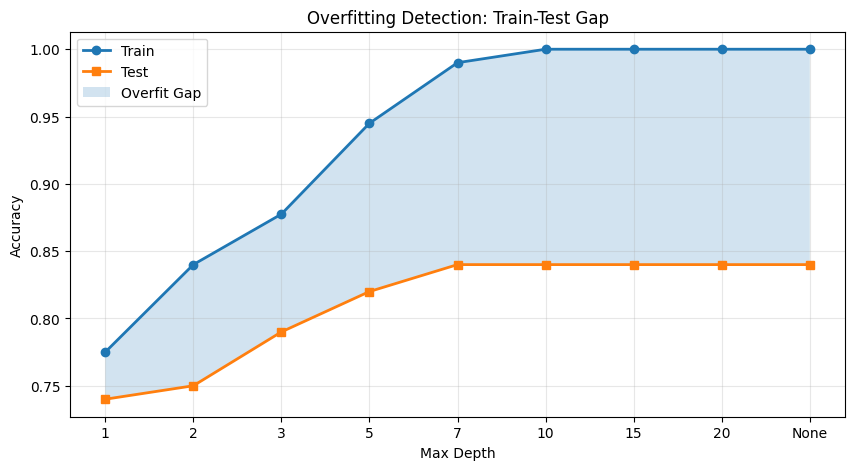


⚠️  Large gap between train and test = OVERFITTING


In [6]:
# Example: Detecting overfitting via train-test gap
depths = [1, 2, 3, 5, 7, 10, 15, 20, None]
train_scores = []
test_scores = []

# Split data
split = int(len(X) * 0.8)
X_tr, X_te = X[:split], X[split:]
y_tr, y_te = y[:split], y[split:]

for depth in depths:
    rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=42)
    rf.fit(X_tr, y_tr)
    train_scores.append(rf.score(X_tr, y_tr))
    test_scores.append(rf.score(X_te, y_te))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(len(depths)), train_scores, 'o-', label='Train', linewidth=2)
plt.plot(range(len(depths)), test_scores, 's-', label='Test', linewidth=2)
plt.fill_between(range(len(depths)), train_scores, test_scores, alpha=0.2, label='Overfit Gap')
plt.xticks(range(len(depths)), [str(d) for d in depths])
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Overfitting Detection: Train-Test Gap')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n⚠️  Large gap between train and test = OVERFITTING")

---
## Interview Question 6: Transaction Costs

**Question**: How do transaction costs affect ML trading strategies?

### Answer:

**Types of costs:**
1. **Commission**: Fixed fee per trade
2. **Spread**: Bid-ask spread
3. **Slippage**: Execution price vs expected price
4. **Market impact**: Large orders moving prices

**Impact on strategies:**
- High-frequency strategies: Costs can eliminate profits
- Signal quality threshold increases
- Optimal holding period changes

**Net Return Formula:**
$$R_{\text{net}} = R_{\text{gross}} - c \times |\Delta \text{Position}|$$

where $c$ = transaction cost rate

In [7]:
# Example: Impact of transaction costs on strategy
np.random.seed(42)

# Simulate strategy returns
n_trades = 100
gross_returns = np.random.randn(n_trades) * 0.01  # ~1% daily vol
gross_returns[gross_returns > 0] *= 1.2  # Slight edge

# Calculate net returns with different cost levels
costs = [0, 0.001, 0.002, 0.005, 0.01]  # 0 to 100 bps
results = []

for cost in costs:
    net_returns = gross_returns - cost  # Simplified: cost per trade
    total_return = (1 + net_returns).prod() - 1
    sharpe = np.sqrt(252) * net_returns.mean() / net_returns.std()
    results.append({
        'Cost (bps)': int(cost * 10000),
        'Total Return': f"{total_return:.2%}",
        'Sharpe': f"{sharpe:.2f}"
    })

print("Impact of Transaction Costs")
print("="*50)
print(pd.DataFrame(results).to_string(index=False))
print("\n⚠️  High costs can turn profitable strategies into losses!")

Impact of Transaction Costs
 Cost (bps) Total Return Sharpe
          0       -4.57%  -0.68
         10      -13.66%  -2.29
         20      -21.89%  -3.91
         50      -42.21%  -8.75
        100      -65.09% -16.82

⚠️  High costs can turn profitable strategies into losses!


---
## Interview Question 7: Ensemble Methods

**Question**: When would you use voting vs stacking ensembles?

### Answer:

**Voting (Simple):**
- Quick to implement
- Works when models are diverse
- Hard voting: Majority rule
- Soft voting: Average probabilities

**Stacking (Complex):**
- Meta-learner combines predictions
- Can learn optimal weights
- Captures non-linear combinations
- Risk of overfitting meta-learner

**Key insight:** Diversity matters more than individual accuracy!

In [8]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42))
]

# Voting ensemble
voting = VotingClassifier(estimators=base_models, voting='soft')

# Stacking ensemble
stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=5
)

# Evaluate with time series CV
tscv = TimeSeriesSplit(n_splits=5)

voting_scores = cross_val_score(voting, X, y, cv=tscv)
stacking_scores = cross_val_score(stacking, X, y, cv=tscv)

print("Ensemble Comparison")
print("="*50)
print(f"Voting: {voting_scores.mean():.4f} ± {voting_scores.std():.4f}")
print(f"Stacking: {stacking_scores.mean():.4f} ± {stacking_scores.std():.4f}")

Ensemble Comparison
Voting: 0.8072 ± 0.0500
Stacking: 0.8361 ± 0.0486


---
## Quick Reference: Key Formulas

### Gini Impurity
$$\text{Gini} = 1 - \sum_{i=1}^{C} p_i^2$$

### Information Gain
$$\text{IG} = H(\text{parent}) - \sum \frac{n_j}{n} H(\text{child}_j)$$

### Sharpe Ratio
$$\text{Sharpe} = \frac{E[R_p - R_f]}{\sigma_p} \times \sqrt{252}$$

### Maximum Drawdown
$$\text{MDD} = \max_t \left( \frac{\text{Peak}_t - \text{Value}_t}{\text{Peak}_t} \right)$$

### OOB Error (Random Forest)
$$\text{OOB Error} = \frac{1}{n} \sum_{i=1}^{n} \mathbb{1}[y_i \neq \hat{y}_i^{\text{OOB}}]$$

---
## Common Pitfalls to Avoid

1. **Look-ahead bias**: Always lag features!
2. **Survivorship bias**: Include delisted stocks
3. **Overfitting**: Use proper validation
4. **Ignoring costs**: Transaction costs matter
5. **Data snooping**: Don't overfit hyperparameters
6. **Regime changes**: Markets evolve over time
7. **Correlation ≠ Causation**: Alpha decays quickly

In [9]:
# Summary of Week 8
summary = """
╔══════════════════════════════════════════════════════════════════╗
║                    WEEK 8 SUMMARY: ML FOR TRADING                ║
╠══════════════════════════════════════════════════════════════════╣
║ Day 1: Decision Trees & Random Forests                          ║
║   - Tree splitting criteria (Gini, Entropy)                     ║
║   - Bagging reduces variance                                    ║
║   - OOB error for validation                                    ║
╠══════════════════════════════════════════════════════════════════╣
║ Day 2: Gradient Boosting (XGBoost, LightGBM)                    ║
║   - Sequential learning reduces bias                            ║
║   - Learning rate vs n_estimators tradeoff                     ║
║   - Regularization prevents overfitting                         ║
╠══════════════════════════════════════════════════════════════════╣
║ Day 3: Feature Engineering                                      ║
║   - Technical indicators as features                            ║
║   - Cross-sectional features                                    ║
║   - Feature selection methods                                   ║
╠══════════════════════════════════════════════════════════════════╣
║ Day 4: Walk-Forward Validation                                  ║
║   - Why K-fold fails for time series                           ║
║   - Rolling vs expanding windows                                ║
║   - Purging and embargo                                         ║
╠══════════════════════════════════════════════════════════════════╣
║ Day 5: Ensemble Methods                                         ║
║   - Model diversity is key                                      ║
║   - Voting vs Stacking                                          ║
║   - Confidence-based trading signals                            ║
╠══════════════════════════════════════════════════════════════════╣
║ Day 6: Strategy Backtesting                                     ║
║   - Complete backtesting framework                              ║
║   - Transaction cost impact                                     ║
║   - Performance metrics                                         ║
╠══════════════════════════════════════════════════════════════════╣
║ Day 7: Interview Prep & Review                                  ║
║   - Common interview questions                                  ║
║   - Key formulas and concepts                                   ║
║   - Pitfalls to avoid                                           ║
╚══════════════════════════════════════════════════════════════════╝
"""
print(summary)


╔══════════════════════════════════════════════════════════════════╗
║                    WEEK 8 SUMMARY: ML FOR TRADING                ║
╠══════════════════════════════════════════════════════════════════╣
║ Day 1: Decision Trees & Random Forests                          ║
║   - Tree splitting criteria (Gini, Entropy)                     ║
║   - Bagging reduces variance                                    ║
║   - OOB error for validation                                    ║
╠══════════════════════════════════════════════════════════════════╣
║ Day 2: Gradient Boosting (XGBoost, LightGBM)                    ║
║   - Sequential learning reduces bias                            ║
║   - Learning rate vs n_estimators tradeoff                     ║
║   - Regularization prevents overfitting                         ║
╠══════════════════════════════════════════════════════════════════╣
║ Day 3: Feature Engineering                                      ║
║   - Technical indicators as features     

## Next Steps

After completing Week 8, you should be able to:

1. ✅ Build ML models for trading signal generation
2. ✅ Properly validate strategies with walk-forward
3. ✅ Engineer features without look-ahead bias
4. ✅ Combine models using ensemble methods
5. ✅ Backtest with realistic transaction costs
6. ✅ Answer common ML trading interview questions

**Coming up in Week 9: Deep Learning Fundamentals**